In [1]:
import pandas as pd
import numpy as np

random_df = pd.read_csv('random_tweets_processed.csv')
depressed_df = pd.read_csv('depressive_tweets_processed.csv')
random_df.tweet = random_df.tweet.astype(str)
depressed_df.tweet = depressed_df.tweet.astype(str)

In [2]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [3]:
X_r = random_df['tweet'].tolist()
X_d = depressed_df['tweet'].tolist()

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(X_d + X_r)

In [5]:
sequence_d = tokenizer.texts_to_sequences(X_d)
sequence_r = tokenizer.texts_to_sequences(X_r)

In [6]:
data_d = pad_sequences(sequence_d, maxlen=280)
data_r = pad_sequences(sequence_r, maxlen=280)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 12635 unique tokens


In [8]:
nb_words = min(20000, len(word_index))

embedding_matrix = np.zeros((nb_words+1, 300))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < 20000:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [9]:
d_rows = len(data_d)
r_rows = len(data_r)

labels_d = np.array([1] * d_rows)
labels_r = np.array([0] * r_rows)

perm_d = np.random.permutation(d_rows)
train_d_idx = perm_d[:int((0.7)*(d_rows))]
val_d_idx = perm_d[int((0.7)*(d_rows)) : int((0.85)*(d_rows))]
test_d_idx = perm_d[int((0.85)*(d_rows)):]

perm_r = np.random.permutation(r_rows)
train_r_idx = perm_r[:int((0.7)*(r_rows))]
val_r_idx = perm_r[int((0.7)*(r_rows)) : int((0.85)*(r_rows))]
test_r_idx = perm_r[int((0.85)*(r_rows)):]

data_train = np.concatenate((data_d[train_d_idx], data_r[train_r_idx]))
labels_train = np.concatenate((labels_d[train_d_idx], labels_r[train_r_idx]))
data_val = np.concatenate((data_d[val_d_idx], data_r[val_r_idx]))
labels_val = np.concatenate((labels_d[val_d_idx], labels_r[val_r_idx]))
data_test = np.concatenate((data_d[test_d_idx], data_r[test_r_idx]))
labels_test = np.concatenate((labels_d[test_d_idx], labels_r[test_r_idx]))

perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [10]:
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D

In [36]:
model = Sequential()

model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                   input_length=280, trainable=False))

model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.2))

model.add(LSTM(300))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [37]:
model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 280, 300)          3790800   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 280, 64)           38464     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 140, 64)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 140, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               438000    
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [38]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 72s 351ms/step - loss: 0.1934 - acc: 0.9330 - val_loss: 0.0605 - val_acc: 0.9843
Epoch 2/10
205/205 [==============================] - 63s 308ms/step - loss: 0.0776 - acc: 0.9728 - val_loss: 0.0536 - val_acc: 0.9836
Epoch 3/10
205/205 [==============================] - 67s 326ms/step - loss: 0.0469 - acc: 0.9841 - val_loss: 0.0420 - val_acc: 0.9900
Epoch 4/10
205/205 [==============================] - 71s 349ms/step - loss: 0.0365 - acc: 0.9888 - val_loss: 0.0387 - val_acc: 0.9914
Epoch 5/10
205/205 [==============================] - 76s 371ms/step - loss: 0.0290 - acc: 0.9902 - val_loss: 0.0406 - val_acc: 0.9879
Epoch 6/10
205/205 [==============================] - 72s 353ms/step - loss: 0.0265 - acc: 0.9914 - val_loss: 0.0373 - val_acc: 0.9907
Epoch 7/10
205/205 [==============================] - 71s 345ms/step - loss: 0.0205 - acc: 0.9937 - val_loss: 0.0430 - val_acc: 0.9907
Epoch 8/10
205/205 [==============================] - 7

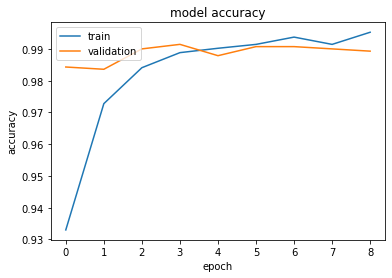

In [40]:
import matplotlib.pyplot as plt


plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

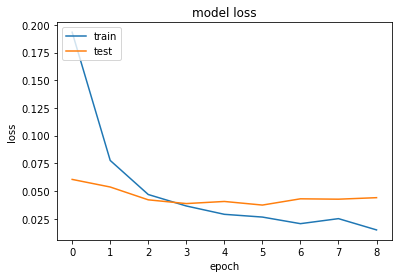

In [41]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
from sklearn.metrics import accuracy_score

labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.57%


In [43]:
from sklearn.metrics import  classification_report

print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.97      0.93      0.95       195

    accuracy                           0.99      1401
   macro avg       0.98      0.96      0.97      1401
weighted avg       0.99      0.99      0.99      1401



In [28]:
X_train = np.concatenate((data_train, data_val))
y_train = np.concatenate((labels_train, labels_val))

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 5000)
logreg.fit(X_train, y_train)
logreg.score(data_test, labels_test)

0.8686652391149179